#Waymo Open Dataset Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates how to use the Waymo Open Dataset with two frames of data. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".



## Install waymo_open_dataset package

In [0]:
!rm -rf waymo-od > /dev/null
!git clone https://github.com/waymo-research/waymo-open-dataset.git waymo-od
!cd waymo-od && git branch -a
!cd waymo-od && git checkout remotes/origin/master
!pip3 install --upgrade pip

In [0]:
!pip3 install waymo-open-dataset-tf-2-1-0==1.2.0

In [1]:
import os
import tensorflow.compat.v1 as tf
import math
import numpy as np
import itertools

tf.enable_eager_execution()

from waymo_open_dataset.utils import range_image_utils
from waymo_open_dataset.utils import transform_utils
from waymo_open_dataset.utils import  frame_utils
from waymo_open_dataset import dataset_pb2 as open_dataset

## Read one frame

Each file in the dataset is a sequence of frames ordered by frame start timestamps. We have extracted two frames from the dataset to demonstrate the dataset format.

In [2]:
FILENAME = 'frames'
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
for data in dataset:
    frame = open_dataset.Frame()
    frame.ParseFromString(bytearray(data.numpy()))
    break

In [3]:
(range_images, camera_projections,
 range_image_top_pose) = frame_utils.parse_range_image_and_camera_projection(
    frame)

###Examine frame context

Refer to [dataset.proto](https://github.com/waymo-research/waymo-open-dataset/blob/master/waymo_open_dataset/dataset.proto) for the data format. The context contains shared information among all frames in the scene.

In [6]:
print(frame.context)

name: "11004685739714500220_2300_000_2320_000"
camera_calibrations {
  name: FRONT
  intrinsic: 2055.556149361639
  intrinsic: 2055.556149361639
  intrinsic: 939.6574698861468
  intrinsic: 641.0721821943271
  intrinsic: 0.03231600849798887
  intrinsic: -0.3214124825527059
  intrinsic: 0.0007932583953709973
  intrinsic: -0.0006257493541333847
  intrinsic: 0.0
  extrinsic {
    transform: 0.9998926849887427
    transform: -0.005993208400016058
    transform: 0.0133678704017097
    transform: 1.5389142447125008
    transform: 0.006042236521329663
    transform: 0.9999751560547995
    transform: -0.003630241176497072
    transform: -0.02363394083934774
    transform: -0.013345781499156929
    transform: 0.003710623431877962
    transform: 0.999904056092345
    transform: 2.115270572975561
    transform: 0.0
    transform: 0.0
    transform: 0.0
    transform: 1.0
  }
  width: 1920
  height: 1280
  rolling_shutter_direction: LEFT_TO_RIGHT
}
camera_calibrations {
  name: FRONT_LEFT
  intrins

## Visualize Camera Images and Camera Labels

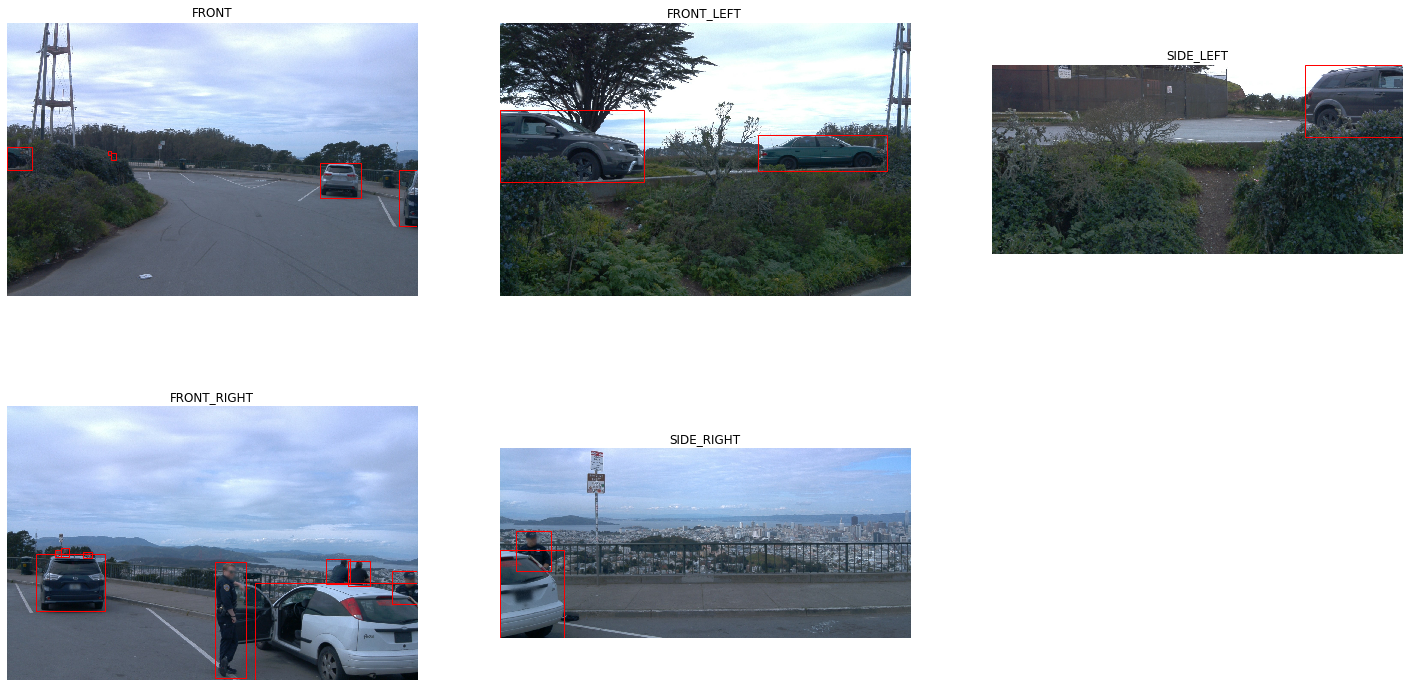

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_camera_image(camera_image, camera_labels, layout, cmap=None):
  """Show a camera image and the given camera labels."""

  ax = plt.subplot(*layout)

  # Draw the camera labels.
  for camera_labels in frame.camera_labels:
    # Ignore camera labels that do not correspond to this camera.
    if camera_labels.name != camera_image.name:
      continue

    # Iterate over the individual labels.
    for label in camera_labels.labels:
      # Draw the object bounding box.
      ax.add_patch(patches.Rectangle(
        xy=(label.box.center_x - 0.5 * label.box.length,
            label.box.center_y - 0.5 * label.box.width),
        width=label.box.length,
        height=label.box.width,
        linewidth=1,
        edgecolor='red',
        facecolor='none'))

  # Show the camera image.
  plt.imshow(tf.image.decode_jpeg(camera_image.image), cmap=cmap)
  plt.title(open_dataset.CameraName.Name.Name(camera_image.name))
  plt.grid(False)
  plt.axis('off')

plt.figure(figsize=(25, 20))

for index, image in enumerate(frame.images):
  show_camera_image(image, frame.camera_labels, [3, 3, index+1])

##Visualize Range Images

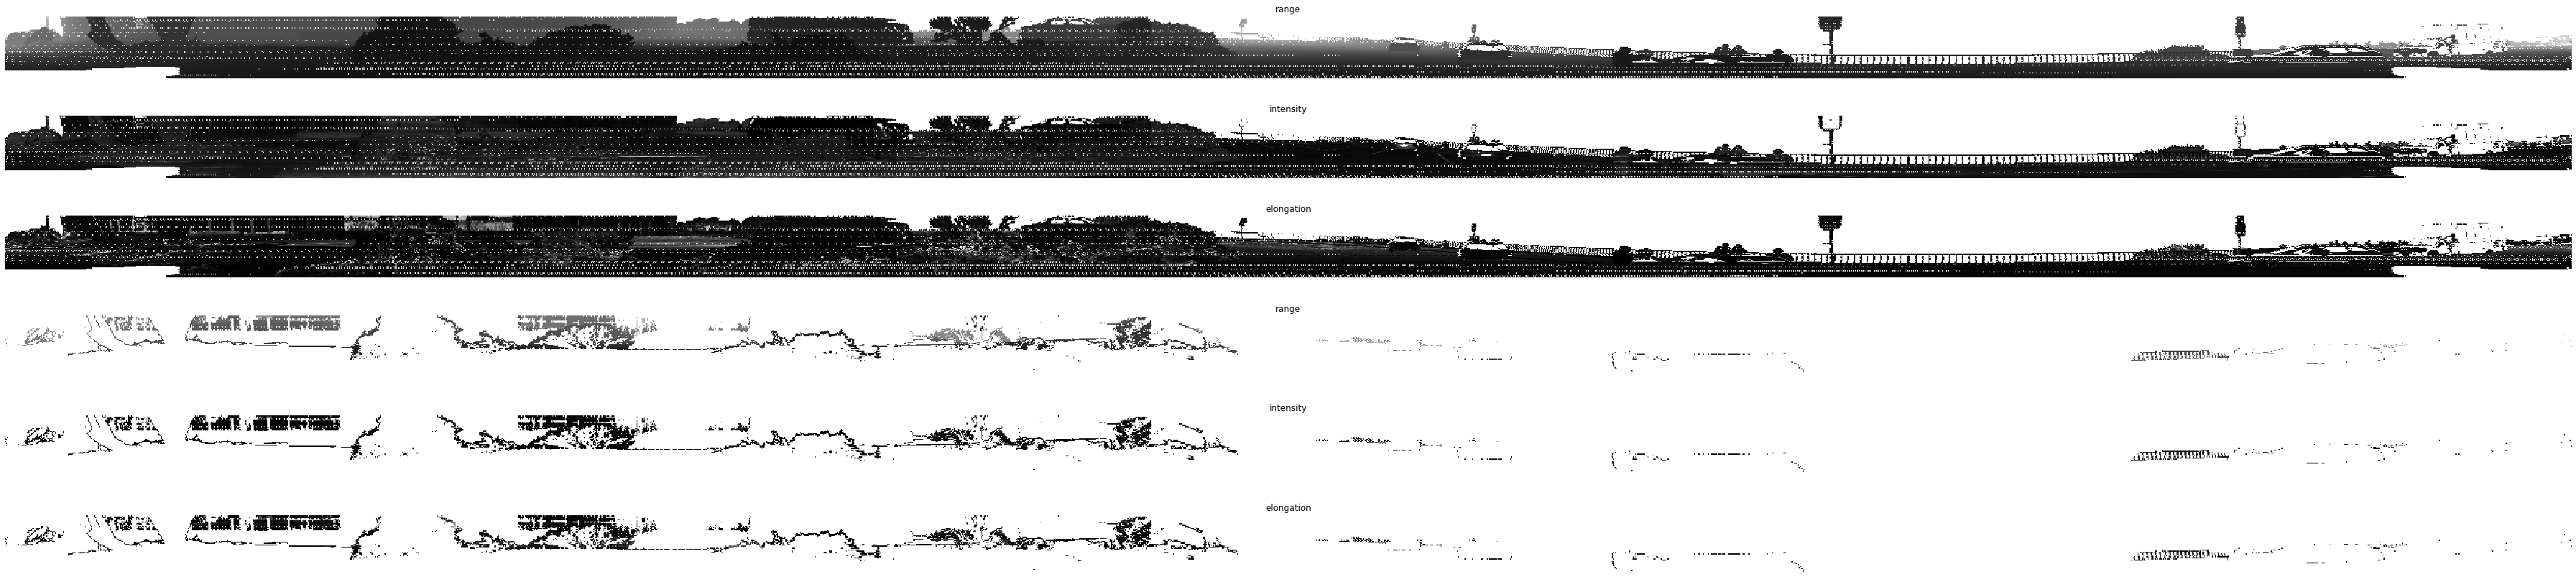

In [9]:
plt.figure(figsize=(64, 20))
def plot_range_image_helper(data, name, layout, vmin = 0, vmax=1, cmap='gray'):
  """Plots range image.

  Args:
    data: range image data
    name: the image title
    layout: plt layout
    vmin: minimum value of the passed data
    vmax: maximum value of the passed data
    cmap: color map
  """
  plt.subplot(*layout)
  plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
  plt.title(name)
  plt.grid(False)
  plt.axis('off')

def get_range_image(laser_name, return_index):
  """Returns range image given a laser name and its return index."""
  return range_images[laser_name][return_index]

def show_range_image(range_image, layout_index_start = 1):
  """Shows range image.

  Args:
    range_image: the range image data from a given lidar of type MatrixFloat.
    layout_index_start: layout offset
  """
  range_image_tensor = tf.convert_to_tensor(range_image.data)
  range_image_tensor = tf.reshape(range_image_tensor, range_image.shape.dims)
  lidar_image_mask = tf.greater_equal(range_image_tensor, 0)
  range_image_tensor = tf.where(lidar_image_mask, range_image_tensor,
                                tf.ones_like(range_image_tensor) * 1e10)
  range_image_range = range_image_tensor[...,0] 
  range_image_intensity = range_image_tensor[...,1]
  range_image_elongation = range_image_tensor[...,2]
  plot_range_image_helper(range_image_range.numpy(), 'range',
                   [8, 1, layout_index_start], vmax=75, cmap='gray')
  plot_range_image_helper(range_image_intensity.numpy(), 'intensity',
                   [8, 1, layout_index_start + 1], vmax=1.5, cmap='gray')
  plot_range_image_helper(range_image_elongation.numpy(), 'elongation',
                   [8, 1, layout_index_start + 2], vmax=1.5, cmap='gray')
frame.lasers.sort(key=lambda laser: laser.name)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 0), 1)
show_range_image(get_range_image(open_dataset.LaserName.TOP, 1), 4)

##Point Cloud Conversion and Visualization

In [10]:
points, cp_points = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose)
points_ri2, cp_points_ri2 = frame_utils.convert_range_image_to_point_cloud(
    frame,
    range_images,
    camera_projections,
    range_image_top_pose,
    ri_index=1)

# 3d points in vehicle frame.
points_all = np.concatenate(points, axis=0)
points_all_ri2 = np.concatenate(points_ri2, axis=0)
# camera projection corresponding to each point.
cp_points_all = np.concatenate(cp_points, axis=0)
cp_points_all_ri2 = np.concatenate(cp_points_ri2, axis=0)

###Examine number of points in each lidar sensor.

First return.

In [11]:
print(points_all.shape)
print(cp_points_all.shape)
print(points_all[0:2])
for i in range(5):
  print(points[i].shape)
  print(cp_points[i].shape)

(126059, 3)
(126059, 6)
[[-51.13867     5.100586    4.3288727]
 [-51.3291      5.243164    4.3369293]]
(108996, 3)
(108996, 6)
(3819, 3)
(3819, 6)
(4918, 3)
(4918, 6)
(3850, 3)
(3850, 6)
(4476, 3)
(4476, 6)


Second return.

In [12]:
print(points_all_ri2.shape)
print(cp_points_all_ri2.shape)
print(points_all_ri2[0:2])
for i in range(5):
  print(points_ri2[i].shape)
  print(cp_points_ri2[i].shape)

(10104, 3)
(10104, 6)
[[-31.75293     6.5751953   3.5490723]
 [-15.777344    4.069336    2.8928528]]
(9868, 3)
(9868, 6)
(53, 3)
(53, 6)
(125, 3)
(125, 6)
(9, 3)
(9, 6)
(49, 3)
(49, 6)


###Show point cloud
3D point clouds are rendered using an internal tool, which is unfortunately not publicly available yet. Here is an example of what they look like.

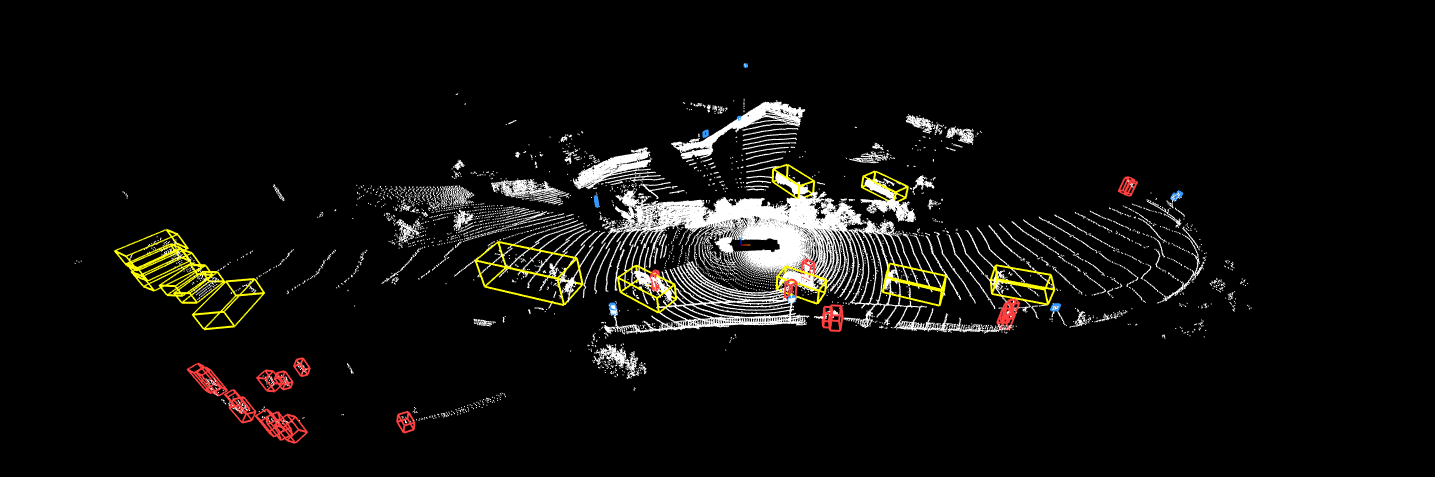

In [14]:
from IPython.display import Image, display
display(Image('3d_point_cloud.png'))

##Visualize Camera Projection

In [15]:
images = sorted(frame.images, key=lambda i:i.name)
cp_points_all_concat = np.concatenate([cp_points_all, points_all], axis=-1)
cp_points_all_concat_tensor = tf.constant(cp_points_all_concat)

# The distance between lidar points and vehicle frame origin.
points_all_tensor = tf.norm(points_all, axis=-1, keepdims=True)
cp_points_all_tensor = tf.constant(cp_points_all, dtype=tf.int32)

mask = tf.equal(cp_points_all_tensor[..., 0], images[0].name)

cp_points_all_tensor = tf.cast(tf.gather_nd(
    cp_points_all_tensor, tf.where(mask)), dtype=tf.float32)
points_all_tensor = tf.gather_nd(points_all_tensor, tf.where(mask))

projected_points_all_from_raw_data = tf.concat(
    [cp_points_all_tensor[..., 1:3], points_all_tensor], axis=-1).numpy()

In [16]:
def rgba(r):
  """Generates a color based on range.

  Args:
    r: the range value of a given point.
  Returns:
    The color for a given range
  """
  c = plt.get_cmap('jet')((r % 20.0) / 20.0)
  c = list(c)
  c[-1] = 0.5  # alpha
  return c

def plot_image(camera_image):
  """Plot a cmaera image."""
  plt.figure(figsize=(20, 12))
  plt.imshow(tf.image.decode_jpeg(camera_image.image))
  plt.grid("off")

def plot_points_on_image(projected_points, camera_image, rgba_func,
                         point_size=5.0):
  """Plots points on a camera image.

  Args:
    projected_points: [N, 3] numpy array. The inner dims are
      [camera_x, camera_y, range].
    camera_image: jpeg encoded camera image.
    rgba_func: a function that generates a color from a range value.
    point_size: the point size.

  """
  plot_image(camera_image)

  xs = []
  ys = []
  colors = []

  for point in projected_points:
    xs.append(point[0])  # width, col
    ys.append(point[1])  # height, row
    colors.append(rgba_func(point[2]))

  plt.scatter(xs, ys, c=colors, s=point_size, edgecolors="none")

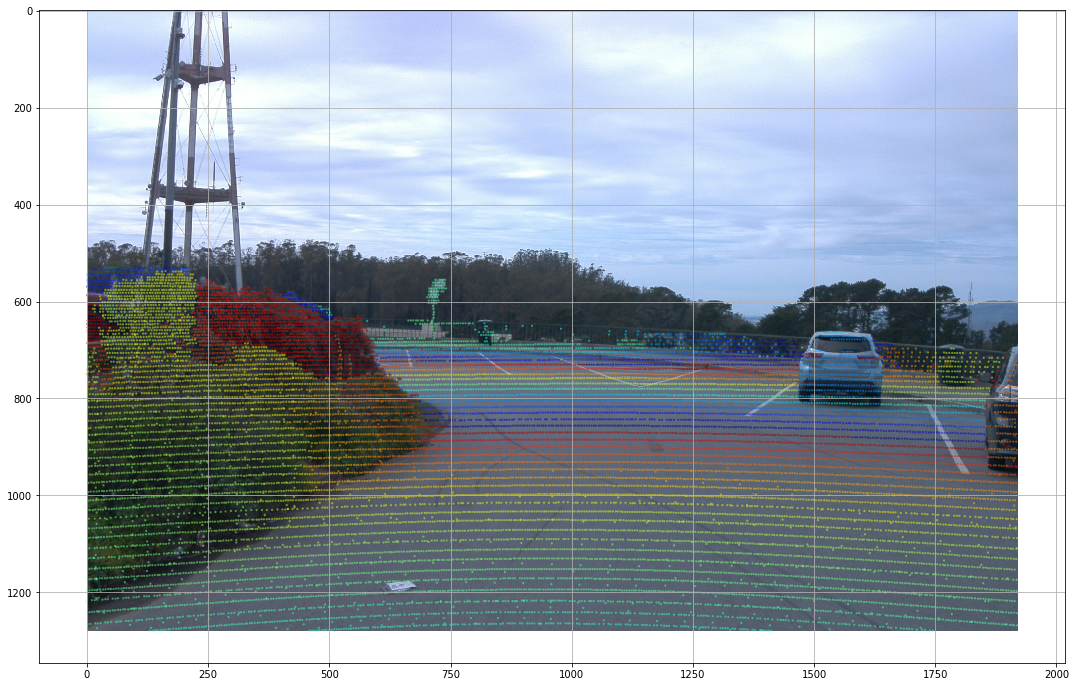

In [17]:
plot_points_on_image(projected_points_all_from_raw_data,
                     images[0], rgba, point_size=5.0)

## Install from source code

The remaining part of this colab covers details of installing the repo form source code which provides a richer API.

### Install dependencies

In [0]:
!sudo apt install build-essential
!sudo apt-get install --assume-yes pkg-config zip g++ zlib1g-dev unzip python3 python3-pip
!wget https://github.com/bazelbuild/bazel/releases/download/0.28.0/bazel-0.28.0-installer-linux-x86_64.sh
!sudo bash ./bazel-0.28.0-installer-linux-x86_64.sh

###Build and test (this can take 10 mins)

Configure .bazelrc. This works with/without Tensorflow. This colab machine has Tensorflow installed.

In [0]:
!cd waymo-od && ./configure.sh && cat .bazelrc && bazel clean

In [0]:
!cd waymo-od && bazel build ... --show_progress_rate_limit=10.0

### Metrics computation
The core metrics computation library is written in C++, so it can be extended to other programming languages. It can compute detection metrics (mAP) and tracking metrics (MOTA). See more information about the metrics on the [website](https://waymo.com/open/next/).

We provide command line tools and TensorFlow ops to call the detection metrics library to compute detection metrics. We will provide a similar wrapper for tracking metrics library in the future. You are welcome to contribute your wrappers.

#### Command line detection metrics computation

The command takes a pair of files for prediction and ground truth. Read the comment in waymo_open_dataset/metrics/tools/compute_detection_metrics_main.cc for details of the data format.

In [0]:
!cd waymo-od && bazel-bin/waymo_open_dataset/metrics/tools/compute_detection_metrics_main waymo_open_dataset/metrics/tools/fake_predictions.bin  waymo_open_dataset/metrics/tools/fake_ground_truths.bin

#### TensorFlow custom op

A TensorFlow op is defined at metrics/ops/metrics_ops.cc. We provide a python wrapper of the op at metrics/ops/py_metrics_ops.py, and a tf.metrics-like implementation of the op at metrics/python/detection_metrics.py. This library requires TensorFlow to be installed.

Install TensorFlow and NumPy.

In [0]:
!pip3 install numpy tensorflow

Reconfigure .bazelrc such that you can compile the TensorFlow ops

In [0]:
!cd waymo-od && ./configure.sh && cat .bazelrc

Run the op and tf.metrics wrapper unit tests which can be referenced as example usage of the libraries.

In [0]:
!cd waymo-od && bazel test waymo_open_dataset/metrics/ops/... && bazel test waymo_open_dataset/metrics/python/...

Run all tests in the repo.

In [0]:
!cd waymo-od && bazel test ...

### Build local PIP package

In [0]:
!cd waymo-od && export PYTHON_VERSION=3 && ./pip_pkg_scripts/build.sh

You can install the locally compiled package or access any c++ binary compiled from this.